# Build a QSPR model for solubility prediction in multiple solvents
## Jacob Albrecht October 2017

This notebook shows an example of how to generate quantitative structure-propery relationship (QSPR) models from solubility data sets. This notebook uses a set of *FAKE* data: plausible, but completely artificial collection of solubility data.  You are free to substitue your own data: all you need are structures saved as [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) strings for your solute, solvent, and the resulting solubility.  This task is quite slow and memory intensive, ~40GB RAM and ~40 CPU-hr should be enough.

# Step 0: Load libraries and print out version numbers for reference

In [107]:
library(plyr,dplyr,impute,camb,caret)
set.seed(8675309)
options(jupyter.plot_mimetypes = 'image/png')  # avoid goofily-rendered plots
options(repr.plot.width=4, repr.plot.height=4)  # set ggplot size

Enable multi-CPU processing:

In [2]:
cl<-makeCluster(parallel::detectCores()-1)  # use N-1 cores
doParallel::registerDoParallel(cl) # fire 'em up!

In [3]:
sessionInfo()

R version 3.2.3 (2015-12-10)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS release 6.7 (Final)

locale:
[1] C

attached base packages:
 [1] grid      parallel  splines   stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] stringr_1.2.0           camb_1.0                directlabels_2017.03.31
 [4] maptools_0.9-2          sp_1.2-5                protr_1.4-1            
 [7] vegan_2.4-4             permute_0.9-4           gridExtra_2.2.1        
[10] gbm_2.1.3               survival_2.38-3         kernlab_0.9-25         
[13] caret_6.0-76            lattice_0.20-33         caTools_1.17.1         
[16] pbapply_1.3-3           ggplot2_2.2.1           impute_1.44.0          
[19] dplyr_0.7.2             plyr_1.8.4             

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.12       assertthat_0.1     digest_0.6.12      foreach_1.4.3     
 [5] IRdisplay_0.3      R6_2.2.2           repr_0.4           MatrixMo

# Step 1: Load Solute and Solvent information
Load data set (again these are *not* real solubility measurments), and make sure that the SMILES are read in as text, not categorical factors:

In [85]:
dat <- read.csv('FAKE_SolubilityData.csv')
dat$solute.SMILES <- as.character(dat$solute.SMILES)
dat$solvent.SMILES <- as.character(dat$solvent.SMILES)

Print out a sample of the solublity data: 

In [86]:
sample_n(dat,10)

,solute,solvent.SMILES,solute.SMILES,Mole.fraction
31704,HDLLAPKLUAUFAN-UHFFFAOYSA-N,CC1=CC=C(C)C=C1,CCOC(=O)C1CCCCN1C(=O)C2=CC=NC=C2,0.001085313
4817,ZQRXTZKVBMHPHX-UHFFFAOYSA-N,CC1=CC=CC=C1,CC(C(=O)O)NC(=O)C1CCCN1C(=O)C(CCSC)NC(=O)C(CC(=O)O)N,0.0009032782
29713,NVAVRMNQZXCMNY-UHFFFAOYSA-N,CCCC([O-])=O,C1CNCC2=C1NN=C2C(=O)N3CCN(C(=O)C3)CC4=CC(=CC=C4)F.Cl,0.002470744
10852,PDWWOTIGDRPLRH-UHFFFAOYSA-N,CCC(C)O,CC(C(=O)C1=CC=C(C=C1)OCC(=O)OC)Br,0.002355548
25256,NYDMRYGEOUSQGH-UHFFFAOYSA-N,CC(O)CO,CCCC(C(=O)NC1=CC=CC=C1OCC2CCCCO2)N,0.007141903
21205,AGFVATPSBQLGOC-UHFFFAOYSA-N,CC(C)C1=CC=C(C)C=C1,CC1=CC=CC(=C1NC(=O)CNC(=O)C2CCN(CC2)CC(=O)NC3=C(C=C(C=C3)C(=O)NC4=C(C=CC=C4F)F)C)C(=O)NC,0.0001531609
11839,SMDSPNDPRMASCR-UHFFFAOYSA-N,CC(C)=O,C1=CC(=CC2=C1C=CN2CC(F)(F)F)[N+](=O)[O-],0.006635602
888,SYFLRWHLXGKQTA-UHFFFAOYSA-N,COC1CCCC1,COC(C1=COC(=N1)C2=CC=C(C=C2)F)OC,0.004050137
25654,ZJLQUSPNFOIVES-UHFFFAOYSA-N,CC(O)=O,C1=CC2=C(C=C1Cl)C(=O)N=C2,0.005810336
649,XDYRNAMIGQZFKQ-MDZDMXLPSA-N,CC(C)CCC([O-])=O,CCCOC1=CC=CC(=C1)C2CC(C3(CC2C(CN3)C(C)C)CCC=CCC)C(C)C,0.004495994


## Inspect data
Visualize the distribuiton of solublities for each solvent:

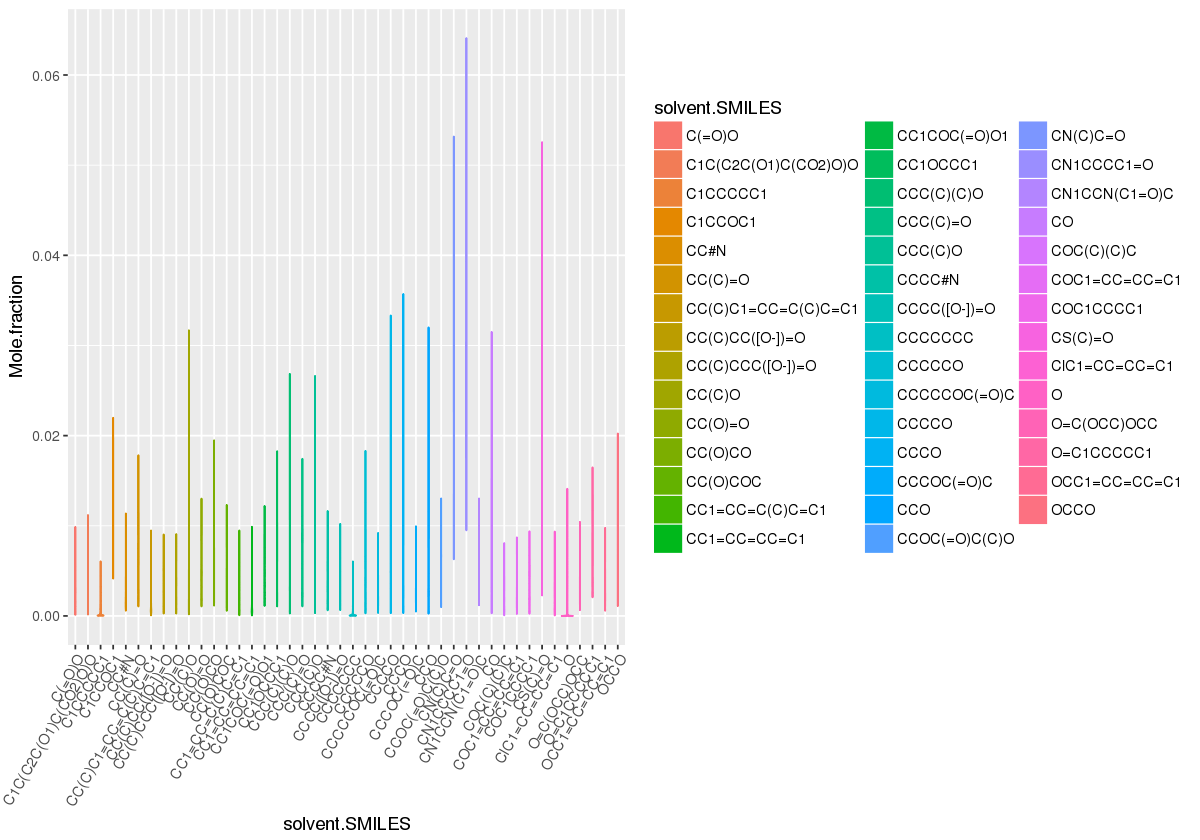

In [84]:
ggplot(dat,aes(x=solvent.SMILES,y=Mole.fraction,color=solvent.SMILES,fill=solvent.SMILES))+
    geom_violin()+theme(axis.text.x=element_text(angle=60,hjust=1))

# Step 2: Generate descriptors from SMILES

Define function to make descriptors from SMILES data:

In [8]:
make_descriptors <- function(smiles){
    # this function generates molecular descriptors from a smiles string, 
    # very powerful, but has an inelegant execution: reading and writing temporary files
    
    # write first file: .smi 
    write.table(smiles,file='test_subset.smi',sep=',',quote=F,col.names=F,row.names=F )
    
    # apply filtering
    StandardiseMolecules(structures.file="./test_subset.smi", 
                   standardised.file="./ONS_standardised.sdf", 
                   removed.file="./ONS_removed.sdf",
                   properties.file = "./ONS_properties.csv",
                   remove.inorganic=TRUE, 
                   fluorine.limit=12, 
                   chlorine.limit=12, 
                   bromine.limit=12, 
                   iodine.limit=12, 
                   min.mass.limit=5, 
                   max.mass.limit=1500)
    
    # generate descriptors:
    descriptorsPadel <- GeneratePadelDescriptors(standardised.file = "./ONS_standardised.sdf",
                                               types=c("2D","3D"),
                                               threads = 8)
    
    descriptors <- RemoveStandardisedPrefix(descriptorsPadel)

    properties <- read.csv("./ONS_properties.csv",header=TRUE, sep="\t")
    properties$Smiles<-as.character(smiles)
    properties$NAME <- as.character(properties$NAME)
    #merge smiles back to descriptor data frame
    descriptors <- right_join(descriptors,properties,by=c('Name'='NAME'))
    return(descriptors %>% filter(Kept==1) %>% select(-Name,-Kept))
}

Generate descriptors for solutes:

In [9]:
solu <- make_descriptors(unique(dat$solute.SMILES))

[1] "Standardising Structures: Reading SMILES (R)"
Verifying that rJava is in the library. If not, it will be installed..
[1] "Generating Descriptors"


Generate descriptors for solvents:

In [10]:
solv <- make_descriptors(unique(dat$solvent.SMILES))

[1] "Standardising Structures: Reading SMILES (R)"
Verifying that rJava is in the library. If not, it will be installed..
[1] "Generating Descriptors"


Record reference solubility, using Methanol as reference solvent:

In [11]:
Ref.solb <- dat %>% select(-solute) %>% dplyr::group_by(solute.SMILES) %>% 
        summarize(Ref.solb = log10(mean(Mole.fraction[solvent.SMILES=='CO']))) %>% data.frame()

Join the solute, solvent, and reference solubility descriptors:

In [12]:
desc <- dat %>% left_join(solu,by=c('solute.SMILES'='Smiles')) %>% 
        left_join(.,solv,by=c('solvent.SMILES'='Smiles'),suffix=c('.solute','.solvent')) %>%
        left_join(.,Ref.solb,by='solute.SMILES') %>% filter(!is.na(Ref.solb))

In [13]:
dim(desc)

[1] 44836  1463

The table of descriptors has 44836 solubility measurements from 1463 descriptors, let's see if any of these are predictive:

# Step 3: Divide into train and test sets by Solute
In the absence of any temporal or other information that could group the solutes together, apply a random sampling of solutes to define the training and testing sets:

In [15]:
groupvar <- desc$solute.SMILES

unique_ids<- sample(unique(groupvar))

## do the train/test split here:
sub_folds <- createFolds(y = unique_ids, list = TRUE, returnTrain = TRUE,k=4)  # approx 75/25 train test split

train.indices <- which(groupvar %in% unique_ids[sub_folds[[1]]])  
test.indices <- which(!(groupvar %in% unique_ids[sub_folds[[1]]]))

Split the descriptors off from the solubility, defining an X matrix of predictors and Y vector of responses:

In [16]:
x <- desc %>% select(-solute.SMILES,-solvent.SMILES,-Mole.fraction)
y <- log10(desc %>% select(Mole.fraction))-desc$Ref.solb  # take log of conc

In [17]:
n_distinct(desc$solute.SMILES[test.indices])

[1] 258

The test set contains 258 unique compounds.  Next clean up and standardize the predictors through a series of operations to remove missing data and highly correlated predictors:

In [18]:
x <- ReplaceInfinitesWithNA(x)  # remove infs
# remove any inf variances:
x <- x[,is.finite(apply(x,2,sd))]

x.imputed.train <- ImputeFeatures(x[train.indices,],k=10) # seperate impute for trainset
x.imputed.test <- ImputeFeatures(x[test.indices,],k=10) # impute for test set


Cluster size 33440 broken into 6380 27060 
Cluster size 6380 broken into 1188 5192 
Done cluster 1188 
Cluster size 5192 broken into 2904 2288 
Cluster size 2904 broken into 1452 1452 
Done cluster 1452 
Done cluster 1452 
Done cluster 2904 
Cluster size 2288 broken into 1092 1196 
Done cluster 1092 
Done cluster 1196 
Done cluster 2288 
Done cluster 5192 
Done cluster 6380 
Cluster size 27060 broken into 17732 9328 
Cluster size 17732 broken into 9460 8272 
Cluster size 9460 broken into 5192 4268 
Cluster size 5192 broken into 2842 2350 
Cluster size 2842 broken into 975 1867 
Done cluster 975 
Cluster size 1867 broken into 334 1533 
Done cluster 334 
Cluster size 1533 broken into 809 724 
Done cluster 809 
Done cluster 724 
Done cluster 1533 
Done cluster 1867 
Done cluster 2842 
Cluster size 2350 broken into 1367 983 
Done cluster 1367 
Done cluster 983 
Done cluster 2350 
Done cluster 5192 
Cluster size 4268 broken into 1276 2992 
Done cluster 1276 
Cluster size 2992 broken into 92

In [19]:
dataset <- list(ids=groupvar,
             holdout.indices=test.indices,
             train.indices= train.indices,
             x.train=x.imputed.train,
             x.holdout=x.imputed.test,
             y.train=y[train.indices,],
             y.holdout=y[test.indices,])

In [20]:
dataset <- RemoveNearZeroVarianceFeatures(dataset)

943 features removed with variance below cutoff


In [21]:
dataset <- PreProcess(dataset)

In [22]:
dataset <- RemoveHighlyCorrelatedFeatures(dataset)

190 features removed with correlation above cutoff


In [23]:
dataset <- GetCVTrainControl(dataset,folds=5,repeats=2)

Do some extra work to make sure that the cross-validaton splits are also on the basis of solute only:

In [25]:
train_ids<-dataset$ids[dataset$train.indices]
unique_train_ids<-unique(train_ids)

sub_folds1 <- createFolds(y = unique_train_ids, list = TRUE, returnTrain = TRUE,k=5)
sub_folds2 <- createFolds(y = unique_train_ids, list = TRUE, returnTrain = TRUE,k=5)

in_train1 <- holdout1 <- vector(mode = "list", length = length(sub_folds1))
in_train2 <- holdout2 <- vector(mode = "list", length = length(sub_folds2))
for(i in seq(along = sub_folds1)) {
  ## Which subjects are in fold i
  sub_in1 <- unique_train_ids[sub_folds1[[i]]]
  sub_in2 <- unique_train_ids[sub_folds2[[i]]]
  ## which rows of the data correspond to those subjects
  in_train1[[i]] <- which(train_ids %in% sub_in1)
  holdout1[[i]]  <- which(!(train_ids %in% sub_in1))
  in_train2[[i]] <- which(train_ids %in% sub_in2)
  holdout2[[i]]  <- which(!(train_ids %in% sub_in2))
}

names(in_train1) <- names(holdout1) <- sapply(names(sub_folds1),function(x){paste0(x,'.Rep1')})
names(in_train2) <- names(holdout2) <- sapply(names(sub_folds2),function(x){paste0(x,'.Rep2')})

dataset$trControl$index <- c(in_train1,in_train2)
dataset$trControl$indexOut <- c(holdout1,holdout2)

# Step 4: Create and Test Regression Models
## Try regression model using PLS

Use PLS model to make predictive model for solubility:

In [98]:
model <- train(dataset$x.train, dataset$y.train, 'pls',
             tuneGrid=expand.grid(ncomp=c(3,6,10,18,30,56,100,180)), trControl=dataset$trControl,
             metric='RMSE',maximize=FALSE,verbose=TRUE)

Aggregating results
Selecting tuning parameters
Fitting ncomp = 56 on full training set


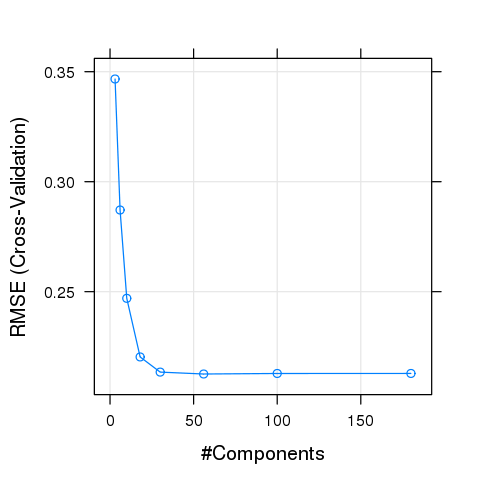

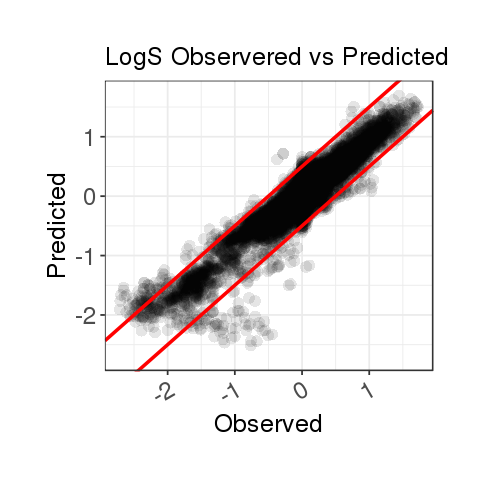

In [97]:
plot(model, metric= "RMSE")

holdout.predictions <- as.vector(predict(model, newdata = dataset$x.holdout))
CorrelationPlot(pred=holdout.predictions, obs=dataset$y.holdout, margin=1, 
              main="LogS Observered vs Predicted - Test Set", PointSize=3, ColMargin="red",PointAlpha=0.1)

In [100]:
print(model)

Partial Least Squares 

33440 samples
  318 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 26752, 26312, 26840, 26708, 27148, 26620, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared 
    3    0.3466807  0.6993919
    6    0.2871223  0.7936764
   10    0.2469759  0.8473523
   18    0.2203227  0.8785294
   30    0.2134365  0.8859025
   56    0.2125739  0.8868378
  100    0.2128120  0.8865974
  180    0.2128216  0.8865855

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was ncomp = 56.


PLS looks pretty OK, RMSE 0.21, with no benefit of using more than 56 components.  But, can a better model be found?

## Try regression model using Random Forest
Use the versatile random forest algorithm to generate a predictive QSPR model.  Use recursive feature elimination to find the most parsimonious model:

In [ ]:
rfe.ctrl <- rfeControl(functions = list(summary = defaultSummary,
                                      fit = rfFuncs$fit,
                                      pred =  rfFuncs$pred,
                                      rank = rfFuncs$rank,
                                      selectSize =function (x, metric, maximize=FALSE) {
                                                    best <- which.min(x[, metric])
                                                    min(x[best, "Variables"])
                                                },
                                      selectVar = rfFuncs$selectVar), 
                     method = 'repeatedcv',
                     number = 5,
                     repeats=1,
                     index = dataset$trControl$index, 
                     indexOut = dataset$trControl$indexOut,
                     allowParallel = TRUE)

model <- rfe(dataset$x.train, dataset$y.train,method='rf',sizes=c(10,30,55,100,180,300,560),
           metric='RMSE',maximize=FALSE,
           rfeControl=rfe.ctrl,
           weights=weights)

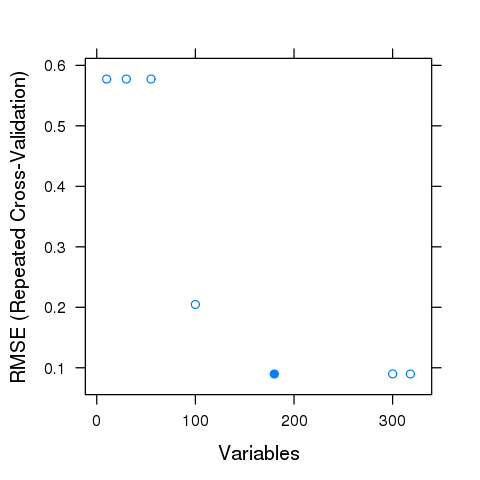

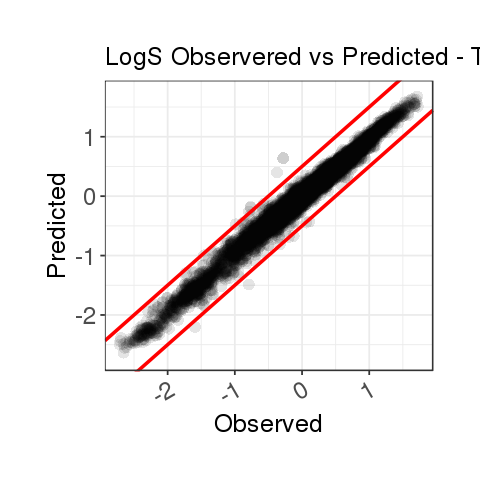

In [105]:
plot(model)

holdout.predictions <- as.vector(predict(model, newdata = dataset$x.holdout))
train.predictions <- as.vector(predict(model, newdata = dataset$x.train))
CorrelationPlot(pred=holdout.predictions, obs=dataset$y.holdout, margin=1, 
              main="LogS Observered vs Predicted - Test Set", PointSize=3, ColMargin="red",PointAlpha=0.1)

In [104]:
print(model)


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 1 times) 

Resampling performance over subset size:

 Variables    RMSE Rsquared   RMSESD RsquaredSD Selected
        10 0.57739   0.1640 0.006177   0.021240         
        30 0.57742   0.1639 0.006184   0.021455         
        55 0.57747   0.1639 0.006154   0.021454         
       100 0.20468   0.9012 0.021145   0.016451         
       180 0.08972   0.9802 0.004677   0.001969        *
       300 0.08988   0.9801 0.004550   0.001879         
       318 0.08973   0.9802 0.004522   0.001870         

The top 5 variables (out of 180):
   ETA_dEpsilon_D.solute, Ref.solb, ALogP.solute, XLogP.solute, BCUTw.1h.solute



# Conclusions

So the results of the (again, *fake*) data set look better with the RF model using 180 variables compared to the best PLS model found.  The improvement is significant a reduction in RMSE by more than half!  When testing different predictive models, always try different fitting algorithms and search over as many hyper-parameters as possible.